In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from full_fred.fred import Fred
import datetime as dt
import requests
from bs4 import BeautifulSoup

# import requests
from bs4 import BeautifulSoup
import re

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.impute import SimpleImputer

In [73]:
fred = Fred('../data/api_key')
fred.get_api_key_file()

'../data/api_key'

### ABOUT THE FEDERAL RESERVE

Via: https://www.federalreserve.gov/aboutthefed.htm



"The Federal Reserve System is the central bank of the United States. It performs five general functions to promote the effective operation of the U.S. economy and, more generally, the public interest. The Federal Reserve

* conducts the nation’s monetary policy to promote maximum employment, stable prices, and moderate long-term interest rates in the U.S. economy;
* promotes the stability of the financial system and seeks to minimize and contain systemic risks through active monitoring and engagement in the U.S. and abroad;
* promotes the safety and soundness of individual financial institutions and monitors their impact on the financial system as a whole;
* fosters payment and settlement system safety and efficiency through services to the banking industry and the U.S. government that facilitate U.S.-dollar transactions and payments; and
* promotes consumer protection and community development through consumer-focused supervision and examination, research and analysis of emerging consumer issues and trends, community economic development activities, and the administration of consumer laws and regulations.



My goal is to predict Federal Reserve Interest Rates into the future by creating several multivariate timeseries forecast models. In order to do that, I will import these datasets:

    Federal Reserve interest rates
    Gross Domestic Product
    Potential Gross Domestic Product
    Gross National Product
    Inflation
    Core inflation
    Unemployment
    Productivity
    Federal Reserve Beige Book transcripts
    Sentiment analysis from Federal Reserve Beige Book transcripts

Before doing any data collection, I will do a bit of EDA on all of the variables in order to understand their relationship with the target (Federal Reserve interest Rates)

## FEDERAL RESERVE INTEREST RATES: (Target Variable)
https://fred.stlouisfed.org/series/FEDFUNDS

    Not Seasonally Adjusted 
    UNITS: Percent
    FREQUENCY: Monthly

In all of the FRED datasets, the actual data is contained in the `value` feature, and the date in the `date` feature. The `realtime_start` and `realtime_end` features report back when this data was fetched, i.e. serve to denote how up to date this querry is.

In [74]:
interest_rates = fred.get_series_df('FEDFUNDS')
interest_rates

,realtime_start,realtime_end,date,value
0,2023-09-18,2023-09-18,1954-07-01,0.80
1,2023-09-18,2023-09-18,1954-08-01,1.22
2,2023-09-18,2023-09-18,1954-09-01,1.07
3,2023-09-18,2023-09-18,1954-10-01,0.85
4,2023-09-18,2023-09-18,1954-11-01,0.83
...,...,...,...,...
825,2023-09-18,2023-09-18,2023-04-01,4.83
826,2023-09-18,2023-09-18,2023-05-01,5.06
827,2023-09-18,2023-09-18,2023-06-01,5.08
828,2023-09-18,2023-09-18,2023-07-01,5.12


All of these metrics have records going back varying amounts of time, and different reporting frequencies. `interest_rates` has monthly reports dating to 1954. These FRED datasets generally don't have nulls; null values are reported as `.`

In [75]:
interest_rates[interest_rates['value'] == '.']

,realtime_start,realtime_end,date,value


No nulls or missing values here.

In [76]:
interest_rates.isna().sum()

realtime_start    0
realtime_end      0
date              0
value             0
dtype: int64

## GROSS DOMESTIC PRODUCT
https://fred.stlouisfed.org/series/GDP
    
    Seasonally Adjusted Annual Rate
    UNITS: Billions of Dollars
    FREQUENCY: Quarterly

In [77]:
gdp = fred.get_series_df('GDP')
gdp

,realtime_start,realtime_end,date,value
0,2023-09-18,2023-09-18,1946-01-01,.
1,2023-09-18,2023-09-18,1946-04-01,.
2,2023-09-18,2023-09-18,1946-07-01,.
3,2023-09-18,2023-09-18,1946-10-01,.
4,2023-09-18,2023-09-18,1947-01-01,243.164
...,...,...,...,...
305,2023-09-18,2023-09-18,2022-04-01,25248.476
306,2023-09-18,2023-09-18,2022-07-01,25723.941
307,2023-09-18,2023-09-18,2022-10-01,26137.992
308,2023-09-18,2023-09-18,2023-01-01,26529.774


In [78]:
gdp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310 entries, 0 to 309
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   realtime_start  310 non-null    object
 1   realtime_end    310 non-null    object
 2   date            310 non-null    object
 3   value           310 non-null    object
dtypes: object(4)
memory usage: 9.8+ KB


In [79]:
len(gdp[gdp['value'] == '.'])

4

In [80]:
gdp.isna().sum()

realtime_start    0
realtime_end      0
date              0
value             0
dtype: int64

So, there are a total of 4 missing rows in the GDP data, which dates back to 1946, and they're all at the beginning. This data is reported quarterly - even so, this is a very small amount of missing data.

One of the Federal Reserve's primary tennants is to:
`"[promote] the safety and soundness of individual financial institutions and monitor their impact on the financial system as a whole"`
The health of the economy as a whole is well represented by GDP, as it represents both the size of the economy, and its growth over time, which is why the Federal Reserve uses it to influnce their decisions regarding interest rate policy. As this data dates back to 1946, I know that this metric will be non-stationary.

Rapidly expanding GDP can result in "overproduction and underconsumption", where production has expanded too much relative to the amount of consumer demand capable of consuming the commodities resulting from this production. 

This phenomena can hold back productivity, as expanding productive capacity may no longer be profitable in many cases - there will not be enough consumer demand to justify additional productivity. Low interest rate policy is often used in order to attempt to stimulate new investment into productivity, thereby expanding GDP, however in general, this may eventually result in "overproduction and underconsumption" as discussed earlier. Other potential issues include asset bubbles (speculative investment into areas of the economy percieved as productive: internet businesses in the late 1990s, mortgage-backed securities in the mid-2000s, etc.), and a strengthening of the labor market (upward pressure on wages) as there is now a stronger than typical demand for labor.



I will analize productivity as a seperate feature.

## Potential GDP
https://fred.stlouisfed.org/series/GDPPOT

    Not Seasonally Adjusted 
    UNITS: Billions of Chained 2012 Dollars (2012 USD adjusted for inflation)

This metric is calculated by the Federal Reserve and the success of the economy in achieving a high percentage of the calculated potential GDP is another useful way of judging economic health. This is known as the output gap:

    Output Gap = Actual Real GDP - Potential GDP
    
I'll use output gap for EDA, but won't include it in the final model as I don't want to induce any multicollinearity.
Since Potential GDP is a projection, the dataset's timeseries extends to the year 2025, so I'll have to remove any future dates later on.

## Gross National Product
https://fred.stlouisfed.org/series/GNP

    Seasonally Adjusted Annual Rate 
    UNITS: Billions of Dollars
    FREQUENCY: Quarterly

In [81]:
gnp = fred.get_series_df('GNP')
gnp

,realtime_start,realtime_end,date,value
0,2023-09-18,2023-09-18,1939-01-01,.
1,2023-09-18,2023-09-18,1939-04-01,.
2,2023-09-18,2023-09-18,1939-07-01,.
3,2023-09-18,2023-09-18,1939-10-01,.
4,2023-09-18,2023-09-18,1940-01-01,.
...,...,...,...,...
333,2023-09-18,2023-09-18,2022-04-01,25456.409
334,2023-09-18,2023-09-18,2022-07-01,25885.432
335,2023-09-18,2023-09-18,2022-10-01,26289.489
336,2023-09-18,2023-09-18,2023-01-01,26654.007


In [82]:
gnp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338 entries, 0 to 337
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   realtime_start  338 non-null    object
 1   realtime_end    338 non-null    object
 2   date            338 non-null    object
 3   value           338 non-null    object
dtypes: object(4)
memory usage: 10.7+ KB


In [83]:
len(gnp[gnp['value'] == '.'].loc[:'2023-09-15'])

21

In [84]:
gnp.isna().sum()

realtime_start    0
realtime_end      0
date              0
value             0
dtype: int64

There are 21 missing historical values out of a total of 338. This is a fairly large amount, but not too much to impute.

Gross National Product is essentially the same as GDP, but includes productivity from US business abroad, i.e. includes more than just the domestic economy.

## Inflation
https://fred.stlouisfed.org/series/FPCPITOTLZGUSA

    Not Seasonally Adjusted 
    UNITS: Percent
    FREQUENCY: Annual

In [89]:
# https://fred.stlouisfed.org/series/FPCPITOTLZGUSA
inflation = fred.get_series_df('FPCPITOTLZGUSA')
inflation.head()

,realtime_start,realtime_end,date,value
0,2023-09-18,2023-09-18,1960-01-01,1.45797598627786
1,2023-09-18,2023-09-18,1961-01-01,1.07072414764723
2,2023-09-18,2023-09-18,1962-01-01,1.19877334820185
3,2023-09-18,2023-09-18,1963-01-01,1.2396694214876
4,2023-09-18,2023-09-18,1964-01-01,1.27891156462583


Notably, this data only has annual frequency, and it's released on Jan 1 of each year.

In [91]:
inflation['value'] = inflation['value'].astype(float)
inflation.describe()

,value
count,63.000000
mean,3.764840
std,2.784628
min,-0.355546
25%,1.855129
50%,3.015075
75%,4.499197
max,13.549202


At one point between now and the 1960s, inflation was over 13%:

In [92]:
inflation[inflation['value'] > 13]

,realtime_start,realtime_end,date,value
20,2023-09-18,2023-09-18,1980-01-01,13.549202


## Core Inflation
https://fred.stlouisfed.org/series/CORESTICKM159SFRBATL

    Seasonally Adjusted 
    UNITS: Percent Change from Year Ago
    FREQUENCY: Monthly

Core inflation considers a smaller subset of goods. As Investopedia explains: https://www.investopedia.com/terms/c/coreinflation.asp

"Core inflation is the change in the costs of goods and services, but it does not include those from the food and energy sectors. This measure of inflation excludes these items because their prices are much more volatile."

Unlike the inflation data which has a yearly frequency, the core inflation data has a monthly frequency, which could make comparing the two a bit challenging.

## Unemployment

https://fred.stlouisfed.org/series/UNRATE/

    Seasonally Adjusted
    UNITS: Percent
    FREQUENCY: Monthly
    
    "The unemployment rate represents the number of unemployed as a percentage of the labor force. Labor force data are restricted to people 16 years of age and older, who currently reside in 1 of the 50 states or the District of Columbia, who do not reside in institutions (e.g., penal and mental facilities, homes for the aged), and who are not on active duty in the Armed Forces."

The Federal Reserve may attempt to combat high inflation by raising interest rates in order to reduce demand in commodities which would require a loan: new cars, houses, and productive capital, although other commodities can be indirectly affected as well. This means that growth in the supply of commodities (productive capacity) may slow, which can also result in less hiring (expansion of variable capital) as the cost of expanding fixed capital (productive capacity) is now much higher due to a higher cost of borrowing. This tends to result in higher rates of unemployment, which can result in massively reduced demand on an economy-wide scale if unemployment reaches a mass scale. This can have a compounding effect where there is now much less demand, warranting even less productive capacity, which results in less demand for labor. This can be considered the tipping point of a recession where undersupply (inflation) can turn into oversupply. This is a simplified explaination, of course.

On the other hand, low interest rates like those seen in the post-2008 era can stimulate growth by making borrowing nearly free, which can lead to lower unemployment due to an expansion in the productive capacity. However, this is limited by the fact that as mentioned previously, there is a finite limit to the amount of productive capacity that the market can absorb due to there being a finite amount of demand. This limit of this demand is itself related to employment due to the fact that the majority of consumers are workers, and changes in unemployment rates will naturally affect the amount of commidities which can be absorbed by the market, as consumer spending by workers will inevitably be much lower during a recession.


## Productivity

Nonfarm Business Sector: Labor Productivity (Output per Hour) for All Workers</br>
https://fred.stlouisfed.org/series/PRS85006092

    Seasonally Adjusted 
    UNITS: Percent Change at Annual Rate
    FREQUENCY: Quarterly
    
    "Labor productivity, or output per hour, is calculated by dividing an index of real output by an index of hours worked of all persons, including employees, proprietors, and unpaid family workers."

All of the above metrics are published on the first day of the month. Beige Book transcripts are not, meaning I will have to create my main dataframe with a daily frequency to capture all the detail.

## Capital Intensity

I ended up not using this metric.

## Beige Book National Summary Collection

In [20]:
def get_national_summary():
    reports = []
    dates = []
    months = [f"0{month}" if month < 10 else f"{month}" for month in range(1,13)]
    bad_urls = []
    
    for year in range(1970, 2024):
        for month in months:
            url = f"https://www.minneapolisfed.org/beige-book-reports/{year}/{year}-{month}-su"
            response = requests.get(url)

            if response.status_code == 200:
                soup = BeautifulSoup(response.text, "html.parser")
                text_data = soup.get_text()
                # remove newline characters
                text_data = re.sub(r'\n+', ' ', text_data)
                # remove carrige return characters
                text_data = re.sub(r'\r+', '', text_data)
                # convert large whitetexts to single spaces
                text_data = re.sub(r' +', ' ', text_data)

                day = text_data.split('Beige Book: National Summary ')
                day = day[1]
                day = day.split(' ')
                day = day[1:2]
                day = int(str(day)[2:-3])
                date = f"{year}-{month}-{day}"
                dates.append(date)
                
                # remove beginning part: have
                if 'views of Federal Reserve officials. ' in text_data:
                    text_data = text_data.split('views of Federal Reserve officials. ')
                    text_data = text_data[1]
                
                # alternate version
                else:
                    text_data = text_data.split('Beige Book: National Summary ')
                    text_data = text_data[1]
                    text_data = text_data.split(' ')
                    text_data = text_data[3:]
                    text_data = (' ').join(text_data)
                    
                # some reports have an "Overall Economic Activity" header
                if 'Overall Economic Activity' in text_data:
                    text_data = text_data.split('Overall Economic Activity')
                    text_data = text_data[1].strip()

                # remove end part
                text_data = text_data.split('We serve the public by pursuing a growing')
                text_data = text_data[0]
                text_data = text_data.strip()
                reports.append(text_data)

            else:
                reports.append(np.nan)
                # setting day to be 01 in order to process as a datetime
                dates.append(f"{year}-{month}-01")
                bad_urls.append(url)

                
    return dates, reports, bad_urls

Although there are reports from each Federal Reserve branch: San Francisco, St. Louis, etc. which would be interesting to seperately process in the future to see if any regional patterns can be found, I focused on parsing only national reports which summarize the overall economic situation.

In [21]:
date, report, bad_urls = get_national_summary()
national_summary = pd.DataFrame(index = date, data = report, columns = ['report'])
national_summary.index = pd.to_datetime(national_summary.index)

In [22]:
bad_urls[:10]

['https://www.minneapolisfed.org/beige-book-reports/1970/1970-01-su',
 'https://www.minneapolisfed.org/beige-book-reports/1970/1970-02-su',
 'https://www.minneapolisfed.org/beige-book-reports/1970/1970-03-su',
 'https://www.minneapolisfed.org/beige-book-reports/1970/1970-04-su',
 'https://www.minneapolisfed.org/beige-book-reports/1972/1972-01-su',
 'https://www.minneapolisfed.org/beige-book-reports/1979/1979-02-su',
 'https://www.minneapolisfed.org/beige-book-reports/1979/1979-06-su',
 'https://www.minneapolisfed.org/beige-book-reports/1979/1979-12-su',
 'https://www.minneapolisfed.org/beige-book-reports/1980/1980-02-su',
 'https://www.minneapolisfed.org/beige-book-reports/1980/1980-06-su']

In [23]:
len(bad_urls)

186

In [24]:
national_summary.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 648 entries, 1970-01-01 to 2023-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   report  462 non-null    object
dtypes: object(1)
memory usage: 10.1+ KB


In [25]:
national_summary.isna().sum()

report    186
dtype: int64

## Sentiment Analysis

In [27]:
sent = SentimentIntensityAnalyzer()
national_summary['sentiment'] = national_summary['report'].apply(lambda x: sent.polarity_scores(x)['compound']
                                     if not pd.isna(x) else np.nan)

In [28]:
national_summary.isna().sum()

report       186
sentiment    186
dtype: int64

In [29]:
national_summary[national_summary.isna() == True]

,report,sentiment
1970-01-01,NaN,NaN
1970-02-01,NaN,NaN
1970-03-01,NaN,NaN
1970-04-01,NaN,NaN
1970-05-20,NaN,NaN
...,...,...
2023-08-01,NaN,NaN
2023-09-06,NaN,NaN
2023-10-01,NaN,NaN
2023-11-01,NaN,NaN


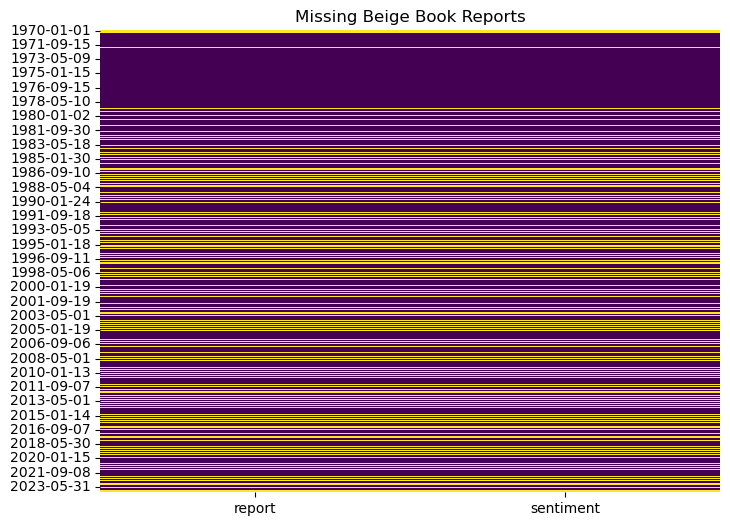

In [30]:
# There's no clear pattern to where the missing reports are from
plot_df = national_summary.copy(deep = True)
plot_df.index = plot_df.index.date
plt.figure(figsize = (8, 6))
sns.heatmap(plot_df.isnull(), cbar = False, cmap = 'viridis')
plt.title('Missing Beige Book Reports')
plt.show()

## FRED Data Collection

In [31]:
def get_fred():
    date_index = pd.date_range(start = '1929-01-01', end = '2023-12-31', freq = 'D')
    fred_df = pd.DataFrame(index = date_index)
    
    for metric in ['FEDFUNDS', 'GDPPOT', 'GDP', 'FPCPITOTLZGUSA', 'CORESTICKM159SFRBATL', 'UNRATE',
                   'gnpca', 'PRS85006092', 'MPU4900083']:
        metric_output = fred.get_series_df(metric)[['date', 'value']]
        # using FRED realtime data to find date of retrieval
        current_date = fred.get_series_df(metric)['realtime_end']
        metric_output.set_index('date', inplace=True)
        metric_output.index = pd.to_datetime(metric_output.index)
        metric_output['value'] = metric_output['value'].apply(lambda v: float(v) if v != '.' else np.nan)
        metric_output.rename(columns = {'value': f"{metric}"}, inplace = True)
        
        fred_df = metric_output.join(fred_df, how='outer')

    fred_df.sort_index(inplace = True)
    fred_df.index = pd.to_datetime(fred_df.index).normalize()
    
    fred_df.rename(columns = {'GDPPOT': 'gdp_potential', 'GDP': 'gdp', 'FPCPITOTLZGUSA': 'inflation',
                            'CORESTICKM159SFRBATL': 'core_inflation', 'UNRATE': 'unemployment',
                            'gnpca': 'gnp', 'PRS85006092': 'productivity',
                            'FEDFUNDS': 'interest_rate'}, inplace = True)
        
    return fred_df, current_date

In [32]:
fred_df, current_date = get_fred()
current_date = current_date[0]

In [33]:
df = fred_df.join(national_summary, how = 'outer')
df = df.loc[:current_date]

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 34592 entries, 1929-01-01 to 2023-09-16
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   capital_intensity  35 non-null     float64
 1   productivity       305 non-null    float64
 2   gnp                94 non-null     float64
 3   unemployment       908 non-null    float64
 4   core_inflation     669 non-null    float64
 5   inflation          63 non-null     float64
 6   gdp                306 non-null    float64
 7   gdp_potential      295 non-null    float64
 8   interest_rate      830 non-null    float64
 9   report             462 non-null    object 
 10  sentiment          462 non-null    float64
dtypes: float64(10), object(1)
memory usage: 3.2+ MB


In [35]:
df.head()

,capital_intensity,productivity,gnp,unemployment,core_inflation,inflation,gdp,gdp_potential,interest_rate,report,sentiment
1929-01-01,NaN,NaN,1120.718,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1929-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1929-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1929-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1929-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
df.tail()

,capital_intensity,productivity,gnp,unemployment,core_inflation,inflation,gdp,gdp_potential,interest_rate,report,sentiment
2023-09-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-09-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-09-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-09-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-09-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
df.isna().sum()

capital_intensity    34557
productivity         34287
gnp                  34498
unemployment         33684
core_inflation       33923
inflation            34529
gdp                  34286
gdp_potential        34297
interest_rate        33762
report               34130
sentiment            34130
dtype: int64

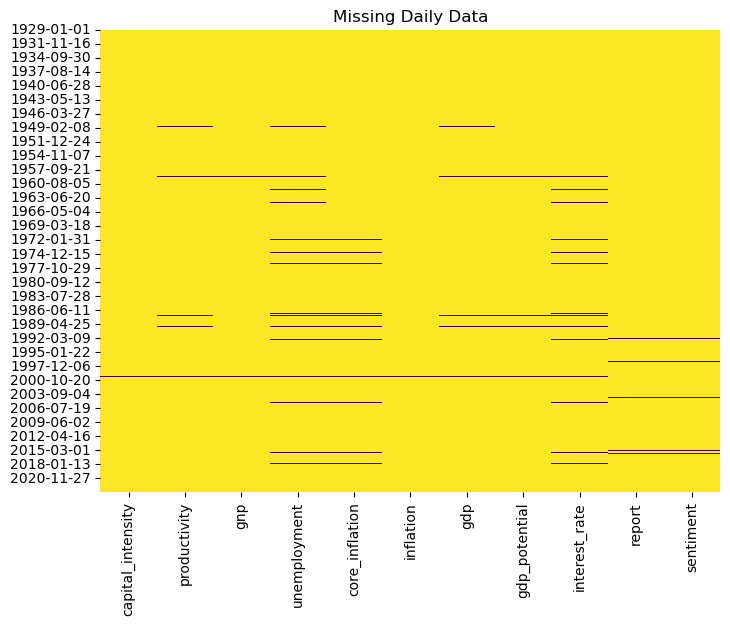

In [38]:
plot_df = df.copy(deep = True)
plot_df.index = plot_df.index.date
plt.figure(figsize = (8, 6))
sns.heatmap(plot_df.isnull(), cbar = False, cmap = 'viridis')
plt.title('Missing Daily Data')
plt.show()

Looking on a daily frequency basis, a large amount of data appears to be missing.

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 34592 entries, 1929-01-01 to 2023-09-16
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   capital_intensity  35 non-null     float64
 1   productivity       305 non-null    float64
 2   gnp                94 non-null     float64
 3   unemployment       908 non-null    float64
 4   core_inflation     669 non-null    float64
 5   inflation          63 non-null     float64
 6   gdp                306 non-null    float64
 7   gdp_potential      295 non-null    float64
 8   interest_rate      830 non-null    float64
 9   report             462 non-null    object 
 10  sentiment          462 non-null    float64
dtypes: float64(10), object(1)
memory usage: 3.2+ MB


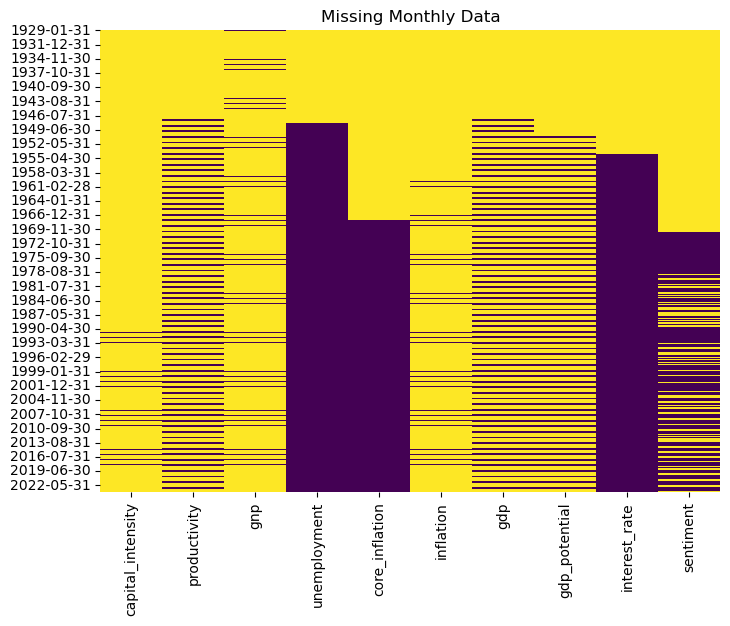

In [41]:
monthly_df = df.drop(columns = ['report']).resample('M').mean()
monthly_df.index = monthly_df.index.date

plt.figure(figsize = (8, 6))
sns.heatmap(monthly_df.isnull(), cbar = False, cmap = 'viridis')
plt.title('Missing Monthly Data')
plt.show()

Resampling to a monthly frequency gives an idea of how many months have no data whatsoever. Inflation is on a yearly frequency and is missing a large amount of data.

## Imputing Missing Data

I will linearly impute missing numeric data, i.e. take the mean between the existing data point, at each missing point. 

In [42]:
df2 = df.copy(deep = True)

In [43]:
# columns to interpolate using mean
num_cols = df.drop(columns = ['report', 'interest_rate']).columns
df[num_cols] = df[num_cols].interpolate()

### Imputing reports data
I'll impute missing reports by carrying the last observation forward as this is how people actually use these reports in real life - people will generally use whatever the latest available report is. 

### Imputing interest rates (target variable)
Deciding how to impute interest rates is more challenging. In reality, interest rates are essentially stepwise, as they remain at a consistent rate between increases: they do not linearly increase or decrease between rates changes as the future rate is unknown, and are selected by humans rather than being an organic phenomena like GDP. That said, this data is on a monthly basis, so if there are multiple rates changes within a month, stepwise imputing (taking the last observation and carrying it forward) could be less realistic than a linear imputation, which would better capture the average trend of rates within a month that has a high frequency of rates changes. That said, Federal Reserve interest rates changes typically don't occur with a high frequency, so the stepwise approach should be the most accurate.

In [44]:
df['report'] = df['report'].ffill()
df['interest_rate'] = df['interest_rate'].ffill()

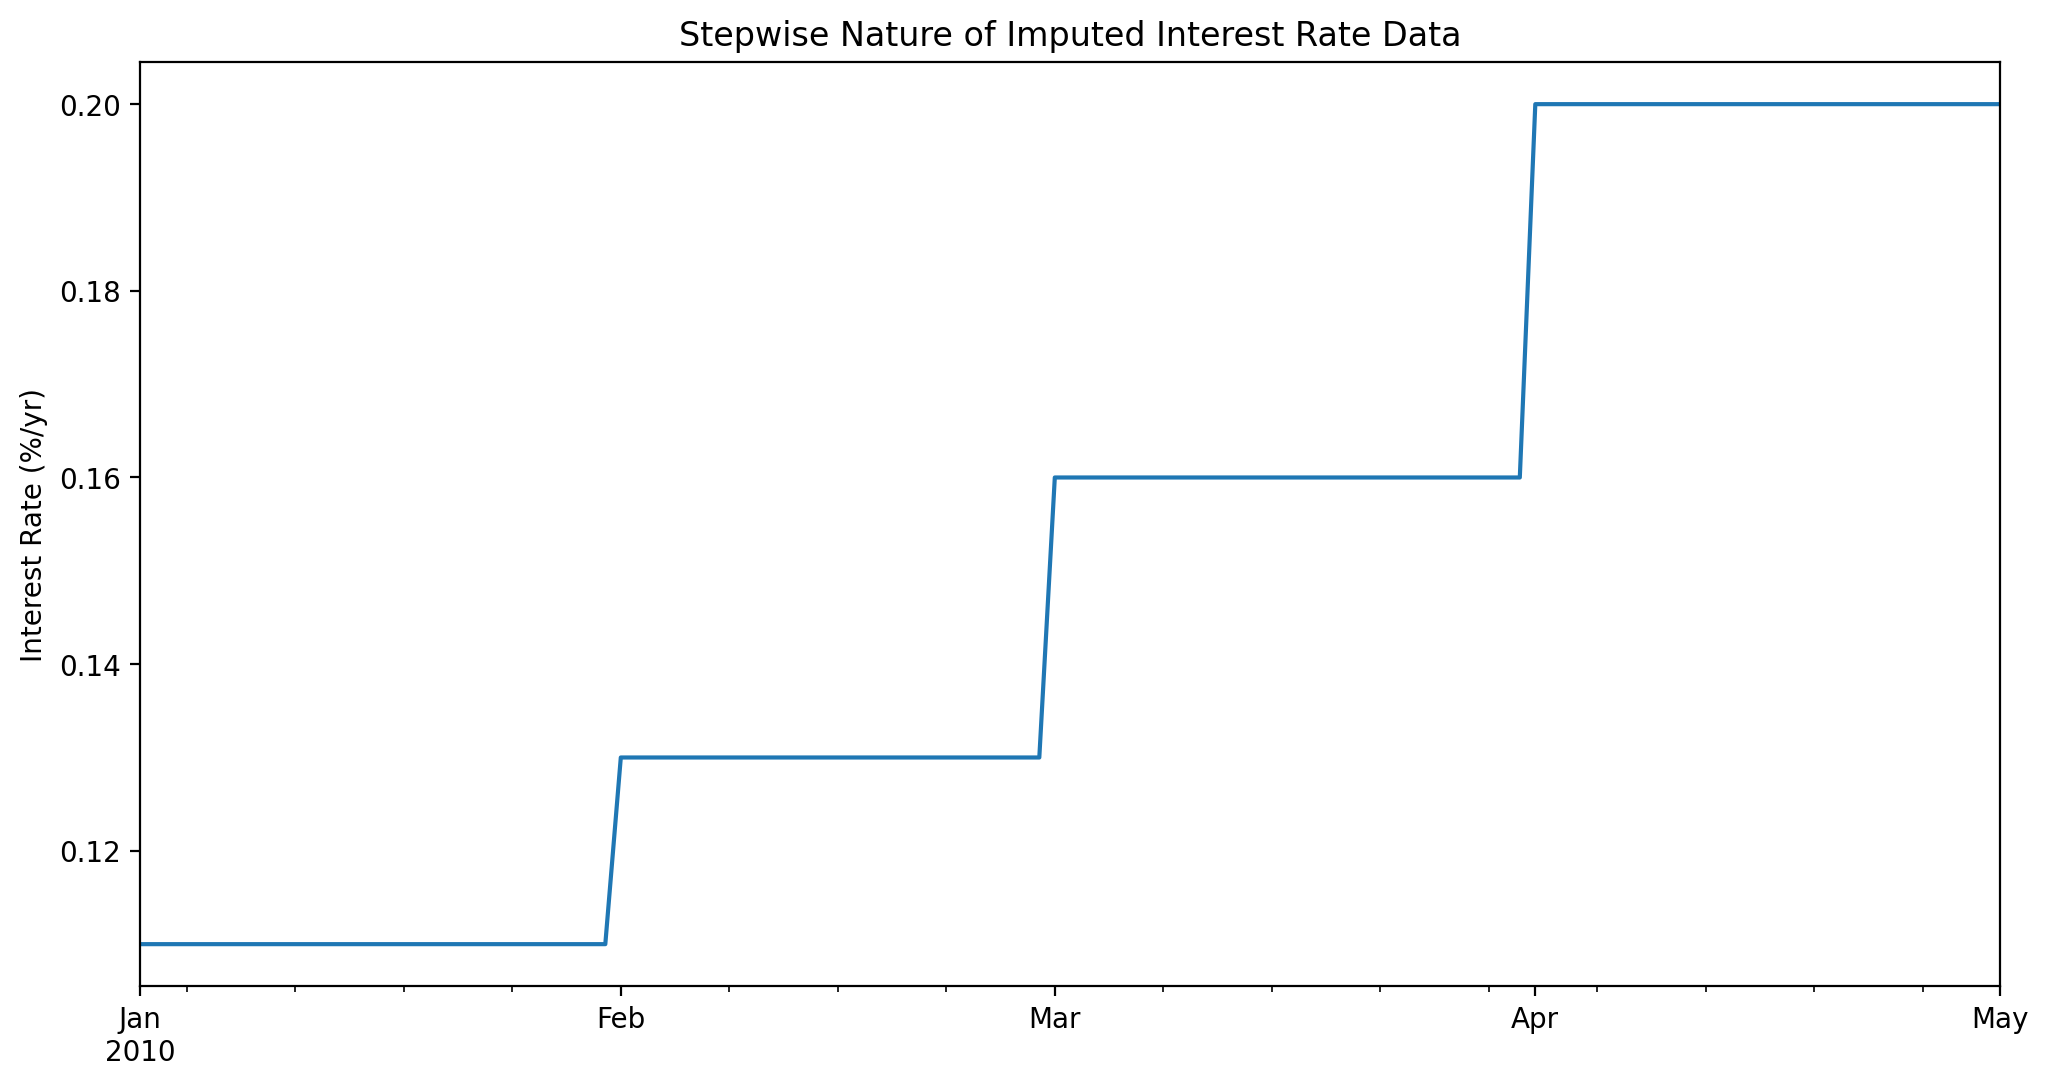

In [45]:
plt.figure(figsize = (12,6), dpi = 200)
df['interest_rate'].loc['2010-01-01':'2010-05-01'].plot();
plt.title('Stepwise Nature of Imputed Interest Rate Data');
plt.ylabel('Interest Rate (%/yr)');

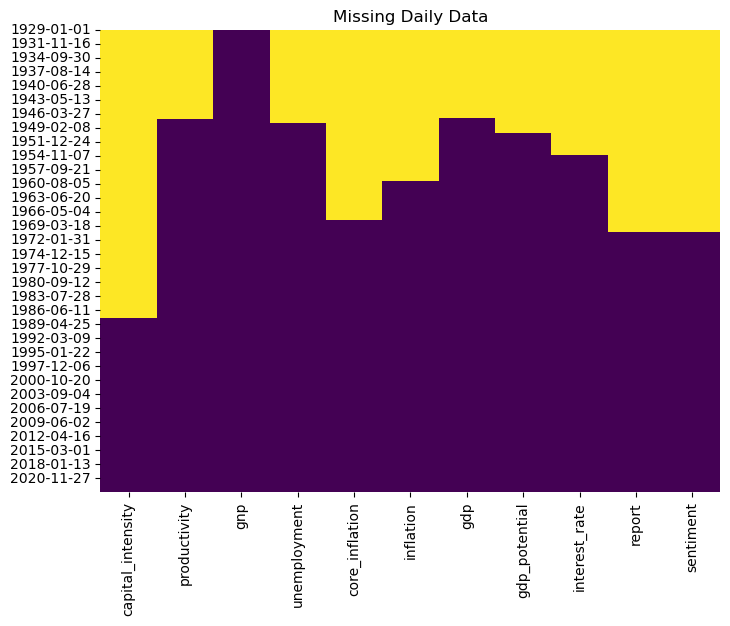

In [46]:
plot_df = df.copy(deep = True)
plot_df.index = plot_df.index.date
plt.figure(figsize = (8, 6))
sns.heatmap(plot_df.isnull(), cbar = False, cmap = 'viridis')
plt.title('Missing Daily Data')
plt.show()

The oldest report is from May 20th, 1970, so I'll create a modeling dataframe which contains any data after that point. Capital intensity won't be included as a final modeling variable.

In [62]:
df[df['report'].isna() == False].head(1)

,capital_intensity,productivity,gnp,unemployment,core_inflation,inflation,gdp,gdp_potential,interest_rate,report,sentiment
1970-05-20,NaN,6.215385,5055.766932,4.86129,7.111779,5.249699,1077.435615,5005.800307,7.95,This initial report of economic conditions in ...,-0.6848


In [63]:
df = df.loc['1970-05-20':]
df.drop(columns = 'capital_intensity', inplace = True)

C:\Users\User\AppData\Local\Temp\ipykernel_15040\2098518844.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns = 'capital_intensity', inplace = True)


In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19478 entries, 1970-05-20 to 2023-09-16
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   productivity    19478 non-null  float64
 1   gnp             19478 non-null  float64
 2   unemployment    19478 non-null  float64
 3   core_inflation  19478 non-null  float64
 4   inflation       19478 non-null  float64
 5   gdp             19478 non-null  float64
 6   gdp_potential   19478 non-null  float64
 7   interest_rate   19478 non-null  float64
 8   report          19478 non-null  object 
 9   sentiment       19478 non-null  float64
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [65]:
df.isna().sum()

productivity      0
gnp               0
unemployment      0
core_inflation    0
inflation         0
gdp               0
gdp_potential     0
interest_rate     0
report            0
sentiment         0
dtype: int64

There is one issue with this approach though, which is that because data at the end of the dataframe won't have any next data point to linearly impute to if it's the final entry, so a horizontal line will be imputed using the final observation:

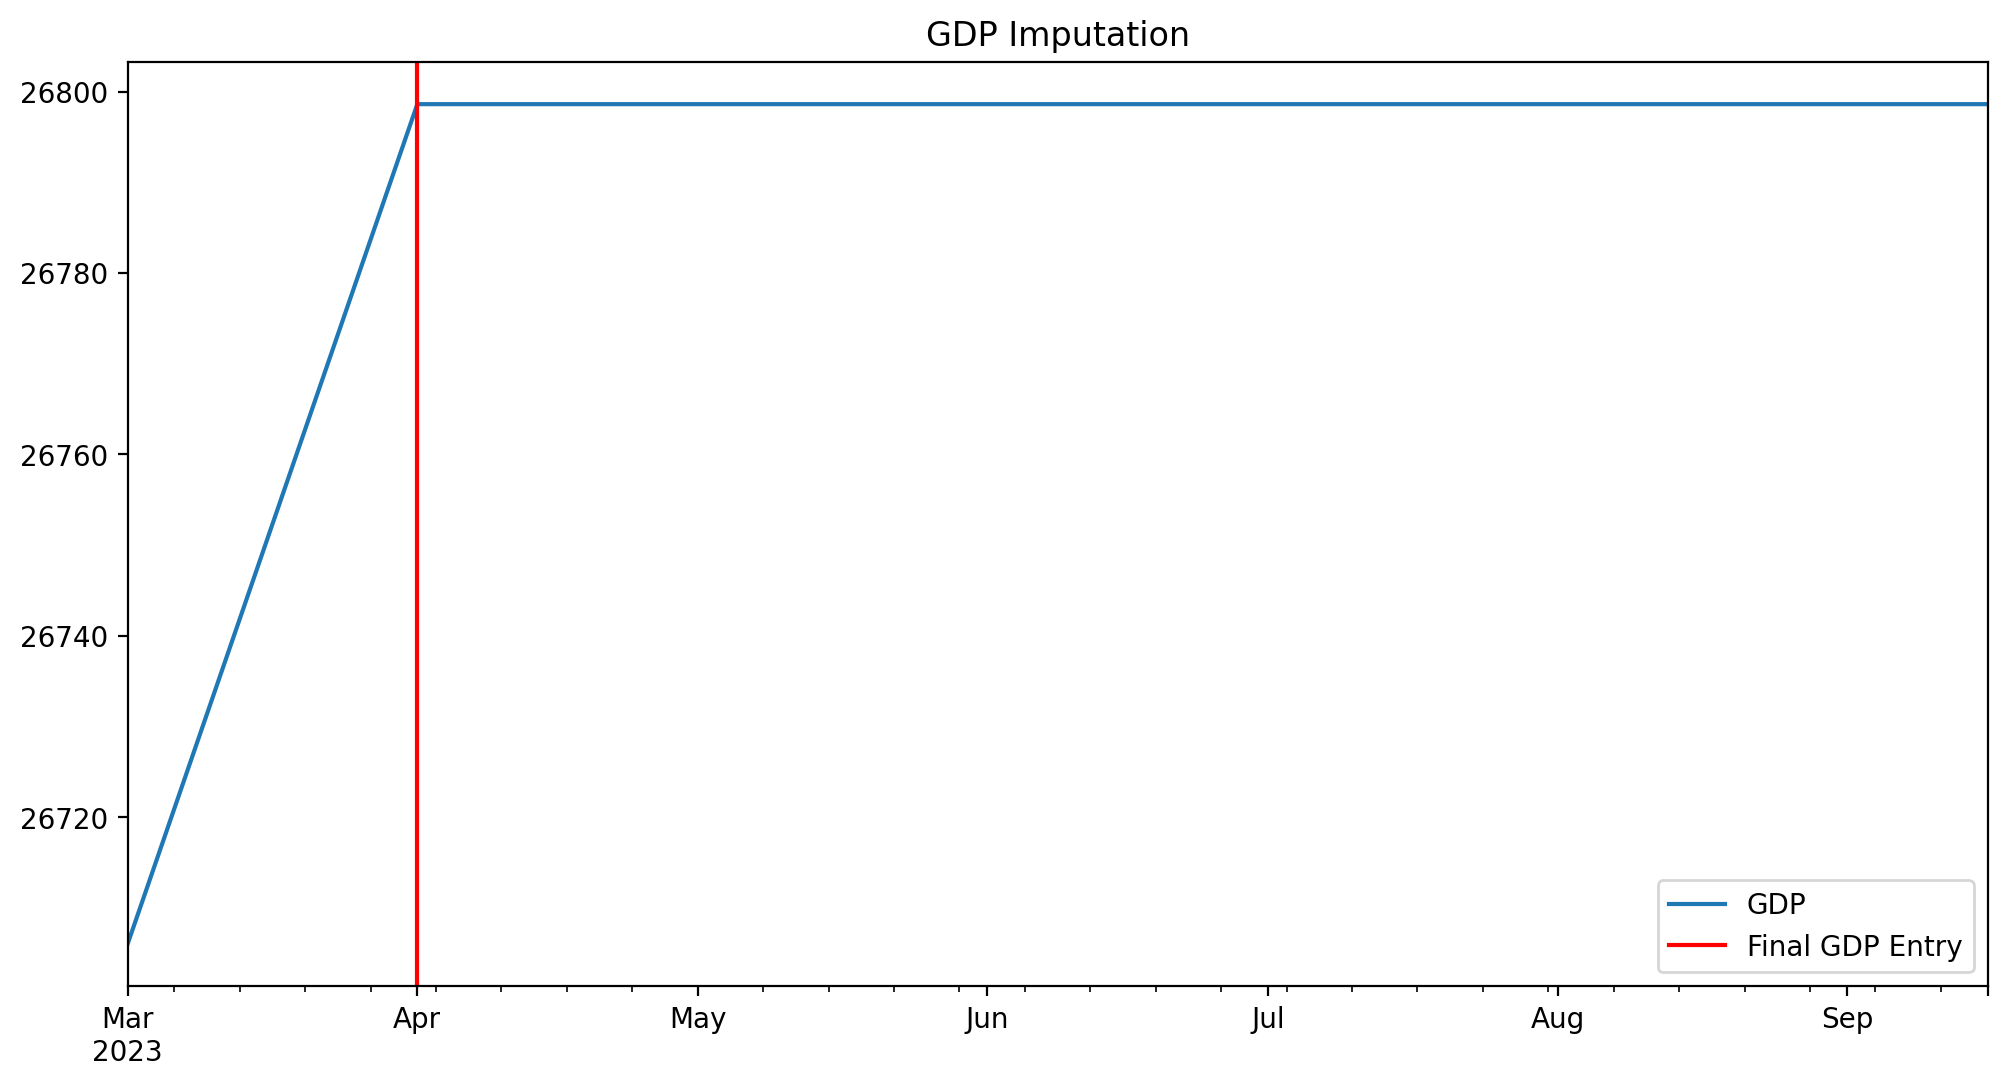

In [47]:
plt.figure(figsize = (12,6), dpi = 200)
df['gdp'].loc['2023-03-01':].plot(label = 'GDP');
plt.axvline(x = '2023-04-01', color = 'r', label = 'Final GDP Entry');
plt.title('GDP Imputation')
plt.legend();

In [59]:
# The last GDP entry is from April 2023
gdp = fred.get_series_df('GDP')
gdp.tail()[['date', 'value']]

,date,value
305,2022-04-01,25248.476
306,2022-07-01,25723.941
307,2022-10-01,26137.992
308,2023-01-01,26529.774
309,2023-04-01,26798.605


I'll check where this issue is occuring by back-imputing all values, not for the sake of actually using, but merely to visualize using the nulls plot:

In [52]:
df2.isna().sum()

capital_intensity    34557
productivity         34287
gnp                  34498
unemployment         33684
core_inflation       33923
inflation            34529
gdp                  34286
gdp_potential        34297
interest_rate        33762
report               34130
sentiment            34130
dtype: int64

In [53]:
df2 = df2.bfill()

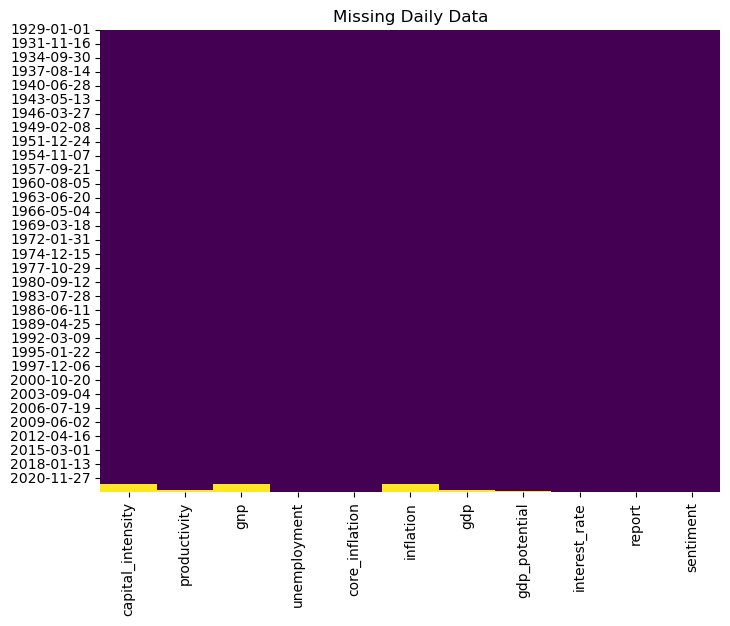

In [54]:
plot_df = df2.copy(deep = True)
plot_df.index = plot_df.index.date
plt.figure(figsize = (8, 6))
sns.heatmap(plot_df.isnull(), cbar = False, cmap = 'viridis')
plt.title('Missing Daily Data')
plt.show()

I'll drop all the nulls, and whatever the final entry is, that's what I'll set to be the end of the main dataframe:

In [61]:
df2.dropna().tail()

,capital_intensity,productivity,gnp,unemployment,core_inflation,inflation,gdp,gdp_potential,interest_rate,report,sentiment
2021-12-28,-0.8,-6.0,20158.225,4.0,3.988659,8.0028,24740.48,20057.88,0.08,Economic activity across the United States exp...,0.9997
2021-12-29,-0.8,-6.0,20158.225,4.0,3.988659,8.0028,24740.48,20057.88,0.08,Economic activity across the United States exp...,0.9997
2021-12-30,-0.8,-6.0,20158.225,4.0,3.988659,8.0028,24740.48,20057.88,0.08,Economic activity across the United States exp...,0.9997
2021-12-31,-0.8,-6.0,20158.225,4.0,3.988659,8.0028,24740.48,20057.88,0.08,Economic activity across the United States exp...,0.9997
2022-01-01,-0.8,-6.0,20158.225,4.0,3.988659,8.0028,24740.48,20057.88,0.08,Economic activity across the United States exp...,0.9997


In [67]:
df = df[:'2022-01-01']

In [70]:
df.to_csv('../data/EDA_df.csv', index_label = False)